In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# basic
import os
import os.path as op
import sys

# common
import numpy as np
import pandas as pd
import xarray as xr
import pickle as pkl

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

#Kmeans
from sklearn.cluster import KMeans

sys.path.insert(0, os.path.join(os.path.abspath(''), '..', ))

#Normalize and DeNormalize functions inside kmeans.py
from codes.kmeans import Normalize, DeNormalize

# Mda
from codes.mda import MaxDiss_Simplified_NoThreshold

# TC Clustering

## 1. Load Data

In [3]:
# path
p_db = op.join(os.getcwd(),'data')

# database precipitation (xls file)
p_dat = op.join(p_db, 'data_tcs.pkl')

In [4]:
data = pd.read_pickle(open(p_dat, 'rb'))
data

,storm,time,lon,lat,pres,sst,mld,category
4471,9245,1981-12-18 12:00:00.000040448,172.000000,-9.000000,997.0,29.580000,64.541672,1
4472,9245,1981-12-19 00:00:00.000040448,169.950012,-9.450001,997.0,27.840000,80.874992,1
4473,9245,1981-12-19 12:00:00.000040448,169.000000,-9.800001,990.0,28.859999,66.666664,1
4474,9245,1981-12-20 00:00:00.000040448,168.199997,-11.000000,987.0,28.719999,68.333336,1
4475,9245,1981-12-20 12:00:00.000040448,167.399994,-12.200000,980.0,28.750000,56.750000,1
...,...,...,...,...,...,...,...,...
14871,13476,2021-01-30 09:00:00.000039936,177.120346,-16.684896,988.0,29.459999,23.416666,1
14872,13476,2021-01-30 12:00:00.000039936,177.399994,-16.799999,986.0,29.500000,23.416666,1
14873,13476,2021-01-30 15:00:00.000039936,177.807175,-17.112688,982.0,29.000000,22.458334,1
14895,13477,2021-01-30 18:00:00.000039936,171.399994,-11.900000,994.0,29.900000,52.250000,1


# MDA

## 2. Select 50 cases using the variables ['pres', 'sst', 'mld']

In [5]:
# subset size, scalar and directional indexes
n_subset = 50           # subset size
ix_scalar = [0, 1, 2]        # x,y,z
ix_directional = []      # 

In [6]:
matrix_mda = np.vstack([data.pres.values, data.sst.values, data.mld.values]).T
matrix_mda.shape #[Number of points] x [Number of dimensions]

(5518, 3)

In [7]:
# MDA algorithm
sel = MaxDiss_Simplified_NoThreshold(matrix_mda, n_subset, ix_scalar, ix_directional)


MaxDiss waves parameters: 5518 --> 50



## 3. Plot scatter with selected points

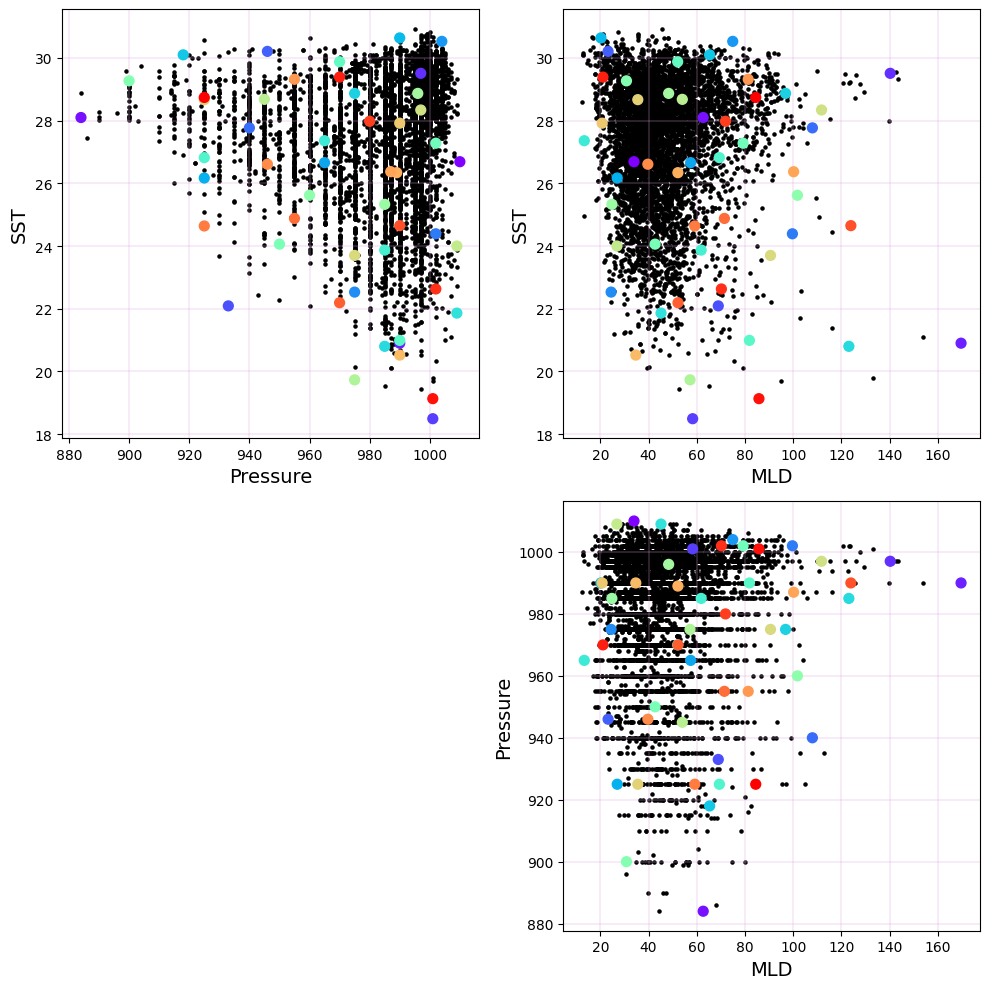

In [8]:
v1, v1_l = data.pres.values, 'Pressure'
v2, v2_l = data.sst.values, 'SST'
v3, v3_l = data.mld.values, 'MLD'
size_point = 5

fig = plt.figure(figsize = [10, 10], tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0,0])
ax.scatter(v1,v2,c='k', s=size_point)
ax.set_xlabel(v1_l, fontsize = 14); ax.set_ylabel(v2_l, fontsize = 14)
ax.grid(':', color = 'plum', linewidth=.3)

ax1 = fig.add_subplot(gs[0,1])
ax1.scatter(v3,v2,c='k', s=size_point)
ax1.set_xlabel(v3_l, fontsize = 14); ax1.set_ylabel(v2_l, fontsize = 14)
ax1.grid(':', color = 'plum', linewidth=.3)

ax2 = fig.add_subplot(gs[1,1])
ax2.scatter(v3,v1,c='k', s=size_point)
ax2.set_xlabel(v3_l, fontsize = 14); ax2.set_ylabel(v1_l, fontsize = 14)
ax2.grid(':', color = 'plum', linewidth=.3)

# Selected points
ax.scatter(sel[:,0], sel[:,1], s=50, c=range(len(sel)), alpha=1, zorder=2, cmap='rainbow')
ax1.scatter(sel[:,2], sel[:,1], s=50, c=range(len(sel)), alpha=1, zorder=2, cmap='rainbow')
im = ax2.scatter(sel[:,2], sel[:,0], s=50, c=range(len(sel)), alpha=1, zorder=2, cmap='rainbow')


# KMA

In [9]:
matrix_kmeans = np.vstack([data.pres.values, data.sst.values, data.mld.values]).T
matrix_kmeans.shape #[Number of points] x [Number of dimensions]

(5518, 3)

In [10]:
# normalize scalar and directional data

ix_scalar = [0,1,2]
ix_directional = []
matrix_kmeans_norm, minis, maxis = Normalize(matrix_kmeans, ix_scalar, ix_directional)


## 5. Obtain 50 clusters

In [11]:
# KMEANS

n_subset = 50
kma = KMeans(n_clusters=n_subset, n_init=100).fit(matrix_kmeans_norm)
bmus = kma.labels_
centroids_norm  = kma.cluster_centers_

centroids = DeNormalize(centroids_norm, ix_scalar, ix_directional, minis, maxis)

## 6. 3d Plot

Text(0.5, 0, 'MLD')

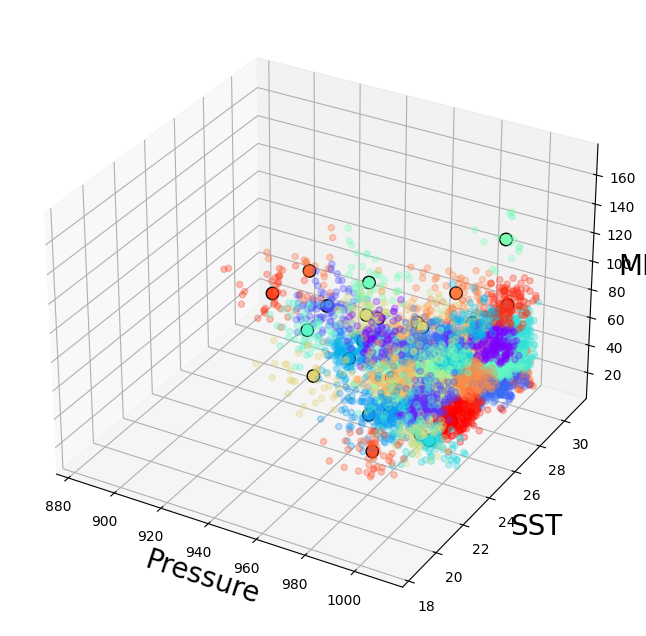

In [12]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data.pres.values, data.sst.values, data.mld.values, c = bmus, alpha=.3, cmap = 'rainbow')

ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], s=80, c = range(n_subset),
           alpha=1, cmap = 'rainbow', edgecolor = 'k')
ax.set_xlabel('Pressure', fontsize = 20)
ax.set_ylabel('SST', fontsize = 20)
ax.set_zlabel('MLD', fontsize = 20)


## 7. Scatter plot

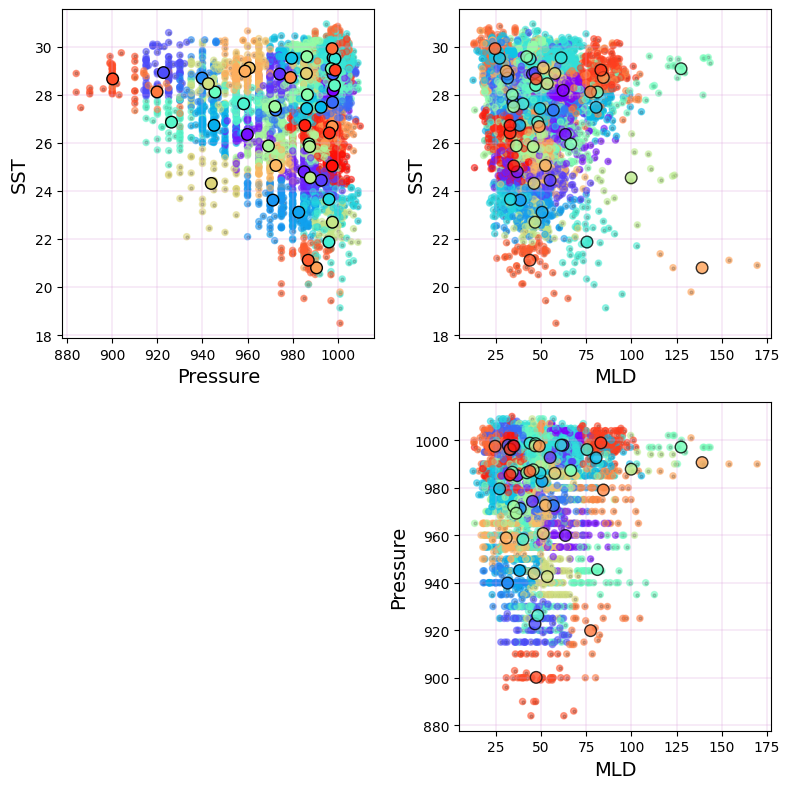

In [13]:
v1, v1_l = data.pres.values, 'Pressure'
v2, v2_l = data.sst.values, 'SST'
v3, v3_l = data.mld.values, 'MLD'

fig = plt.figure(figsize = [8, 8], tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0,0])
ax.scatter(v1,v2,c='k', s=5, alpha=.3)
ax.set_xlabel(v1_l, fontsize = 14); ax.set_ylabel(v2_l, fontsize = 14)
ax.grid(':', color = 'plum', linewidth=.3)

ax1 = fig.add_subplot(gs[0,1])
ax1.scatter(v3,v2,c='k', s=5, alpha=.3)
ax1.set_xlabel(v3_l, fontsize = 14); ax1.set_ylabel(v2_l, fontsize = 14)
ax1.grid(':', color = 'plum', linewidth=.3)


ax2 = fig.add_subplot(gs[1,1])
ax2.scatter(v3,v1,c='k', s=5, alpha=.3)
ax2.set_xlabel(v3_l, fontsize = 14); ax2.set_ylabel(v1_l, fontsize = 14)
ax2.grid(':', color = 'plum', linewidth=.3)

# Centroids
im = ax.scatter(centroids[:,0], centroids[:,1], s=70, c=range(len(centroids)), cmap='rainbow',
                vmin=0, vmax=n_subset, alpha=1, edgecolor = 'black', zorder=3)

ax1.scatter(centroids[:,2], centroids[:,1], s=70, c=range(len(centroids)), cmap='rainbow',
                vmin=0, vmax=n_subset, alpha=.8, edgecolor = 'black', zorder=3)

ax2.scatter(centroids[:,2], centroids[:,0], s=70, c=range(len(centroids)), cmap='rainbow',
                vmin=0, vmax=n_subset, alpha=.8, edgecolor = 'black', zorder=3)

#Cluster
im = ax.scatter(v1, v2, c=bmus, s=20, cmap='rainbow', vmin=0, vmax=n_subset,
                alpha=.5, label = 'Data Points')

im = ax1.scatter(v3, v2, c=bmus, s=20, cmap='rainbow', vmin=0, vmax=n_subset,
                alpha=.5, label = 'Data Points')

im = ax2.scatter(v3, v1, c=bmus, s=20, cmap='rainbow', vmin=0, vmax=n_subset,
                alpha=.5, label = 'Data Points')

# Compare MDA and KMeans

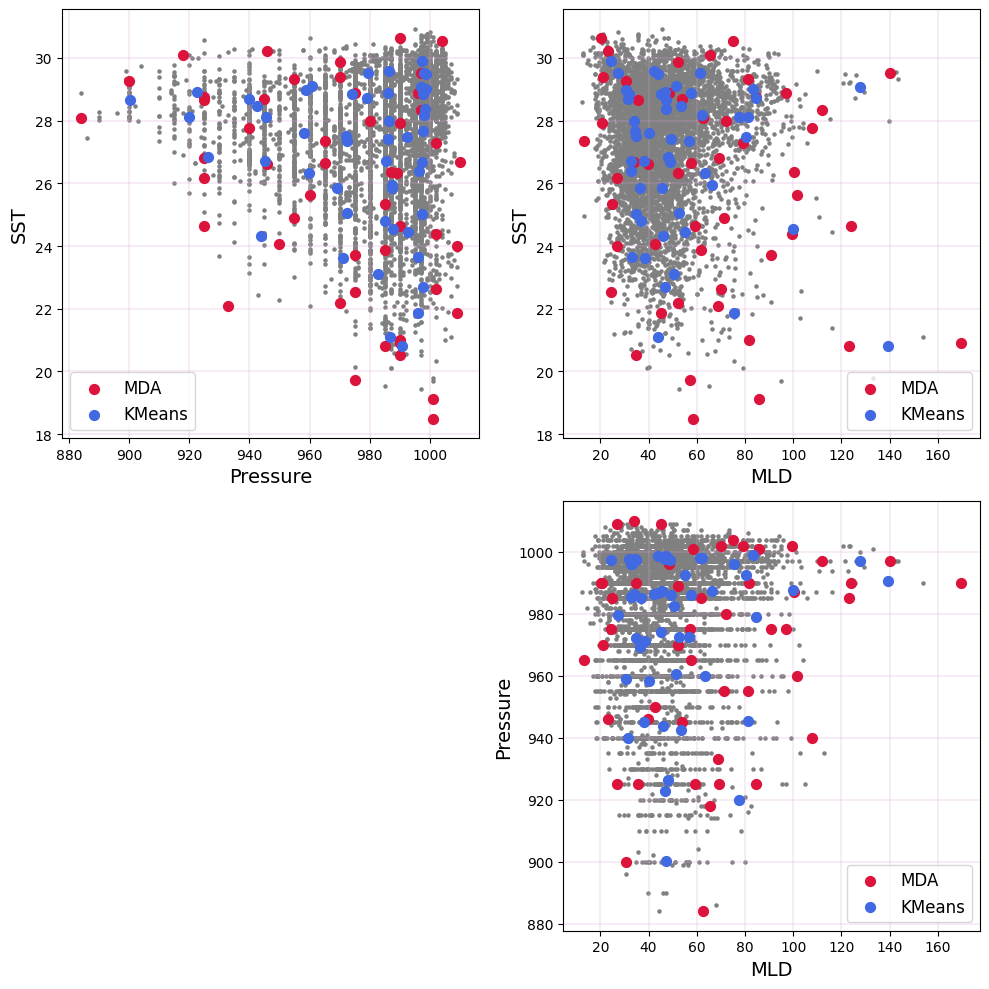

In [14]:
v1, v1_l = data.pres.values, 'Pressure'
v2, v2_l = data.sst.values, 'SST'
v3, v3_l = data.mld.values, 'MLD'
size_point = 5

fig = plt.figure(figsize = [10, 10], tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0,0])
ax.scatter(v1,v2,c='grey', s=size_point)
ax.set_xlabel(v1_l, fontsize = 14); ax.set_ylabel(v2_l, fontsize = 14)
ax.grid(':', color = 'plum', linewidth=.3)

ax1 = fig.add_subplot(gs[0,1])
ax1.scatter(v3,v2,c='grey', s=size_point)
ax1.set_xlabel(v3_l, fontsize = 14); ax1.set_ylabel(v2_l, fontsize = 14)
ax1.grid(':', color = 'plum', linewidth=.3)

ax2 = fig.add_subplot(gs[1,1])
ax2.scatter(v3,v1,c='grey', s=size_point)
ax2.set_xlabel(v3_l, fontsize = 14); ax2.set_ylabel(v1_l, fontsize = 14)
ax2.grid(':', color = 'plum', linewidth=.3)

# Selected points (MDA)
ax.scatter(sel[:,0], sel[:,1], s=50, c='crimson', alpha=1, zorder=2, label = 'MDA')
ax1.scatter(sel[:,2], sel[:,1], s=50, c='crimson', alpha=1, zorder=2, label = 'MDA')
im = ax2.scatter(sel[:,2], sel[:,0], s=50, c='crimson', alpha=1, zorder=2, label = 'MDA')


# Selected points (KMA)
ax.scatter(centroids[:,0], centroids[:,1], s=50, c='royalblue', alpha=1, zorder=2, label = 'KMeans')
ax1.scatter(centroids[:,2], centroids[:,1], s=50, c='royalblue', alpha=1, zorder=2, label = 'KMeans')
im = ax2.scatter(centroids[:,2], centroids[:,0], s=50, c='royalblue', alpha=1, zorder=2, label = 'KMeans')

ax.legend(fontsize = 12)
ax1.legend(fontsize = 12)
ax2.legend(fontsize = 12)